In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
tf.merge_all_summaries = tf.summary.merge_all
tf.train.SummaryWriter = tf.summary.FileWriter

In [ ]:
data = input_data.read_data_sets(".",one_hot = True)

In [3]:
#add gaussian noise
train_images = data.train.images + np.random.normal(0, 0.05, (55000, 784))

In [4]:
def plot_images(img):
    plt.imshow(img.reshape(28,28),cmap="binary")
    plt.show()

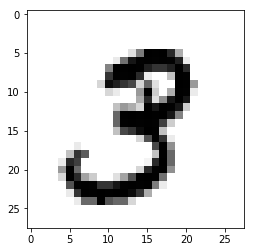

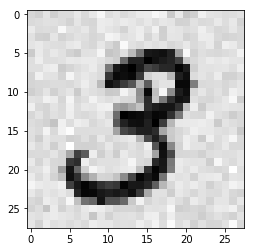

In [5]:
plot_images(data.train.images[1,:])
plot_images(train_images[1, :])

In [6]:
img = tf.placeholder(tf.float32, [None, 784])
x_image = tf.reshape(img, [-1, 28, 28, 1])

h11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x_image)
h12 = tf.keras.layers.MaxPool2D((2, 2), padding='same')(h11)
h21 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(h12)
h22 = tf.keras.layers.MaxPool2D((2, 2), padding='same')(h21)
h31 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(h22)
h32 = tf.keras.layers.MaxPool2D((2, 2), padding='same')(h31)
h41 = tf.keras.layers.Conv2D(25, (3, 3), activation='relu', padding='same')(h32)
encoded = tf.keras.layers.MaxPool2D((2, 2), padding='same')(h41)
# the encoded image representation is (2, 2, 25) i.e. 100-dimensional

d01 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
d02 = tf.keras.layers.UpSampling2D((2, 2))(d01)
d11 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(d02)
d12 = tf.keras.layers.UpSampling2D((2, 2))(d11)
d21 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(d12)
d22 = tf.keras.layers.UpSampling2D((2, 2))(d21)
d31 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(d22)
d32 = tf.keras.layers.UpSampling2D((2, 2))(d31)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d32)

denoise = tf.reshape(decoded, [-1, 784])
origin = tf.placeholder(tf.float32, [None, 784])

In [7]:
loss = tf.reduce_mean(tf.norm(denoise - origin, axis=1))
optim = tf.train.GradientDescentOptimizer(learning_rate = 0.02).minimize(loss)

In [9]:
#running results for convolutional neural network
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
#Make batches to train
num_iter = 20000
batch_size = 256
loss_val = []
iteration = []
for i in range(num_iter):
    idx = np.random.choice(55000, [batch_size], False)
    batch_noise = train_images[idx][:]
    batch_origin = data.train.images[idx][:]
    _, l = sess.run([optim, loss],feed_dict = {img: batch_noise, origin: batch_origin})
    if i % 1000 == 0:
        print(l)

13.465595
5.6535783
5.0822973
4.8420506
4.7502375
4.550349
4.697706
4.4125175
4.4466343
4.290387
4.195059
4.369527
4.1838775
4.150566
4.1096115
4.005748
4.3219514
4.0217133
4.106628
3.8643103


original test image


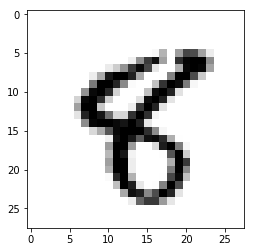

original test image with noise


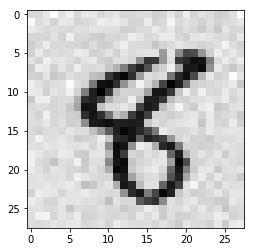

reconstructed image


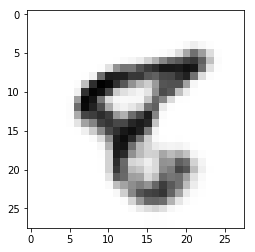

In [68]:
# plot result
idx = [84]
batch_noise = data.test.images[idx][:] + np.random.normal(0, 0.05, (1, 784))
batch_origin = data.test.images[idx][:]
batch_denoise1 = sess.run([denoise],feed_dict = {img: batch_noise, origin: batch_origin})

print("original test image")
plot_images(batch_origin[0, :])
print("original test image with noise")
plot_images(batch_noise[0, :])
print("reconstructed image")
plot_images(batch_denoise1[0][0, :])